<a href="https://colab.research.google.com/github/jorgemar723/3DObjectReconstruction/blob/main/notebooks/real_photos_reconstruction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install trimesh

import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import trimesh
from google.colab import files
import os

print("Libraries imported successfully!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 736.5/736.5 kB 12.9 MB/s eta 0:00:00
Libraries imported successfully!


In [5]:
# Upload photos from your device
print("Please upload 10-20 photos of your object (taken from different angles):")
print("Tips: Good lighting, avoid blur, walk around the object in a circle\n")

uploaded = files.upload()

# Create directory and save files
os.makedirs('real_object_views', exist_ok=True)

image_files = []
for filename in sorted(uploaded.keys()):
    filepath = f'real_object_views/{filename}'
    with open(filepath, 'wb') as f:
        f.write(uploaded[filename])
    image_files.append(filepath)

print(f"\n Successfully uploaded {len(image_files)} images")
print("Image files:", image_files)

Please upload 10-20 photos of your object (taken from different angles):
Tips: Good lighting, avoid blur, walk around the object in a circle



Saving IMG_2013.JPG to IMG_2013 (1).JPG
Saving IMG_2020.JPG to IMG_2020.JPG
Saving IMG_2019.JPG to IMG_2019.JPG
Saving IMG_2018.JPG to IMG_2018.JPG
Saving IMG_2017.JPG to IMG_2017.JPG
Saving IMG_2016.JPG to IMG_2016.JPG
Saving IMG_2015.JPG to IMG_2015.JPG
Saving IMG_2014.JPG to IMG_2014 (1).JPG
Saving IMG_2012.JPG to IMG_2012 (1).JPG

✓ Successfully uploaded 9 images
Image files: ['real_object_views/IMG_2012 (1).JPG', 'real_object_views/IMG_2013 (1).JPG', 'real_object_views/IMG_2014 (1).JPG', 'real_object_views/IMG_2015.JPG', 'real_object_views/IMG_2016.JPG', 'real_object_views/IMG_2017.JPG', 'real_object_views/IMG_2018.JPG', 'real_object_views/IMG_2019.JPG', 'real_object_views/IMG_2020.JPG']


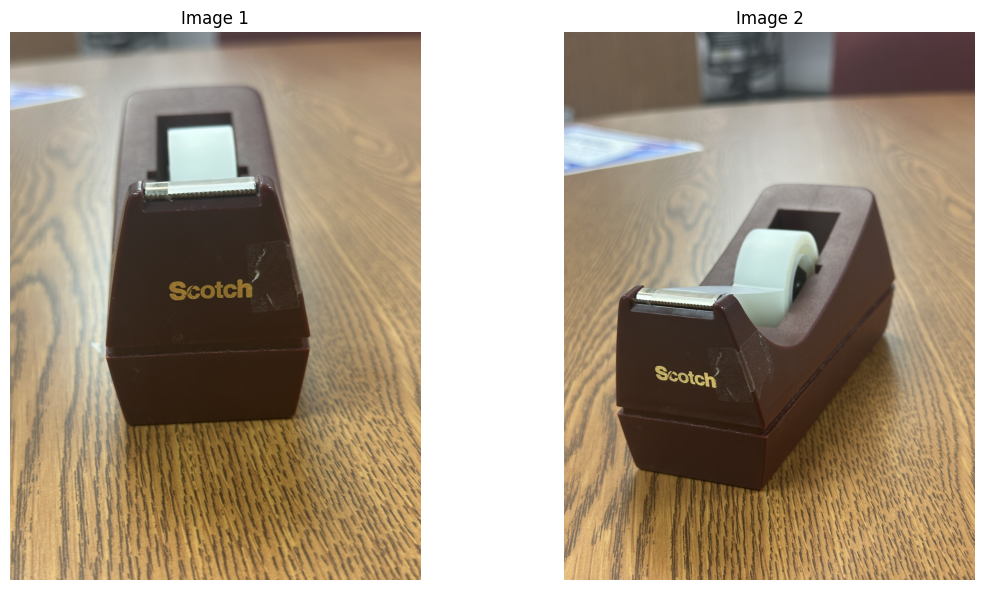

Image 1 shape: (4032, 3024)
Image 2 shape: (4032, 3024)


In [6]:
# Load first two images for reconstruction
if len(image_files) < 2:
    raise ValueError("Need at least 2 images for reconstruction!")

img1 = cv2.imread(image_files[0])
img2 = cv2.imread(image_files[1])

# Convert to RGB for display (OpenCV loads as BGR)
img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

# Display the images
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(img1_rgb)
axes[0].set_title('Image 1')
axes[0].axis('off')
axes[1].imshow(img2_rgb)
axes[1].set_title('Image 2')
axes[1].axis('off')
plt.tight_layout()
plt.show()

# Convert to grayscale for processing
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

print(f"Image 1 shape: {gray1.shape}")
print(f"Image 2 shape: {gray2.shape}")

Detected 6083 keypoints in image 1
Detected 10741 keypoints in image 2


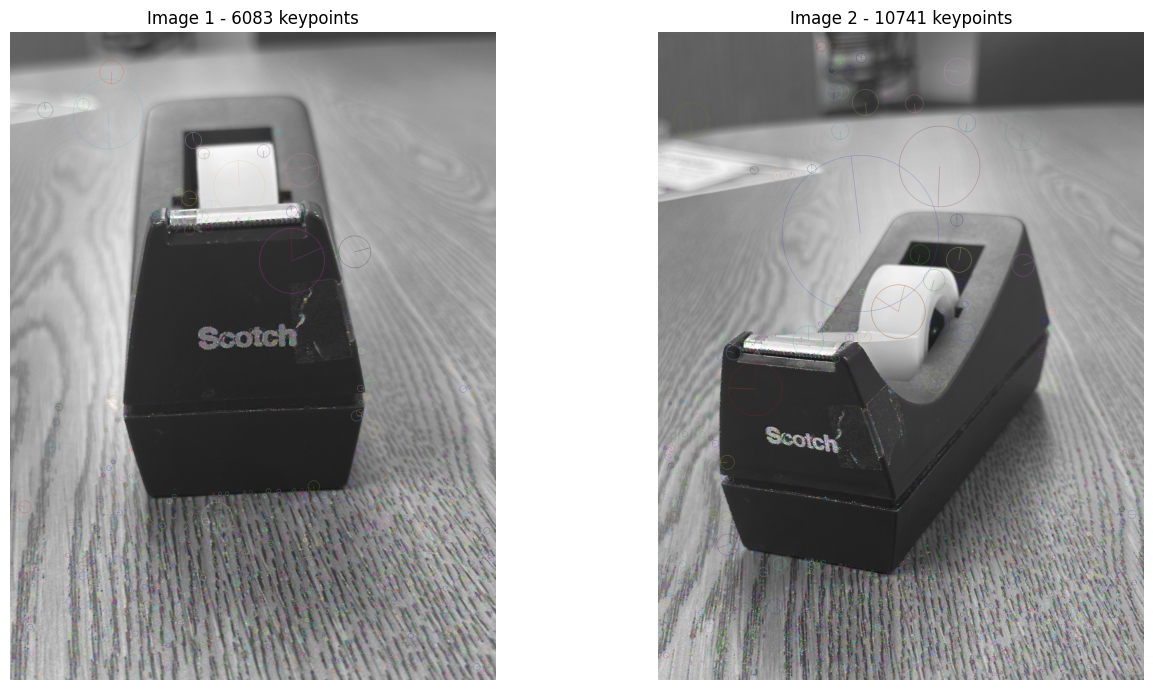

In [7]:
# Initialize SIFT detector
sift = cv2.SIFT_create()

# Detect keypoints and compute descriptors
keypoints1, descriptors1 = sift.detectAndCompute(gray1, None)
keypoints2, descriptors2 = sift.detectAndCompute(gray2, None)

print(f"Detected {len(keypoints1)} keypoints in image 1")
print(f"Detected {len(keypoints2)} keypoints in image 2")

# Visualize keypoints
img1_keypoints = cv2.drawKeypoints(gray1, keypoints1, None,
                                    flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img2_keypoints = cv2.drawKeypoints(gray2, keypoints2, None,
                                    flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

fig, axes = plt.subplots(1, 2, figsize=(14, 7))
axes[0].imshow(img1_keypoints)
axes[0].set_title(f'Image 1 - {len(keypoints1)} keypoints')
axes[0].axis('off')
axes[1].imshow(img2_keypoints)
axes[1].set_title(f'Image 2 - {len(keypoints2)} keypoints')
axes[1].axis('off')
plt.tight_layout()
plt.show()


Found 6083 initial matches
1565 good matches after ratio test


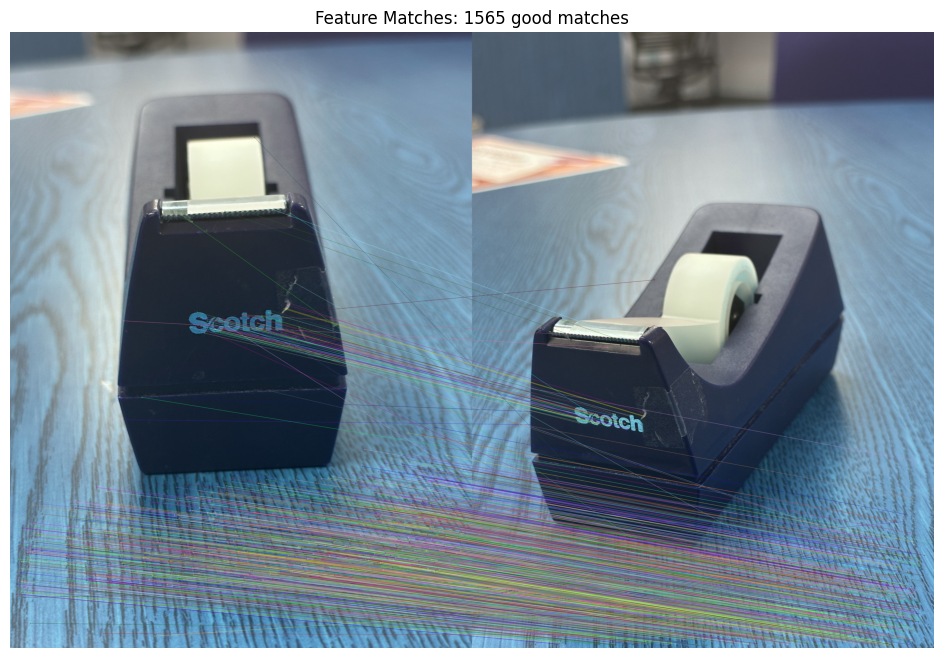

In [10]:
# Create brute force matcher
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)

# Match descriptors between two images
matches = bf.knnMatch(descriptors1, descriptors2, k=2)

# Apply Lowe's ratio test
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

print(f"Found {len(matches)} initial matches")
print(f"{len(good_matches)} good matches after ratio test")

# Visualize matches
img_matches = cv2.drawMatches(img1, keypoints1, img2, keypoints2,
                              good_matches, None,
                              flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(16, 8))
plt.imshow(img_matches)
plt.title(f'Feature Matches: {len(good_matches)} good matches')
plt.axis('off')
plt.show()


In [12]:
# Extract matched point coordinates
points1 = np.float32([keypoints1[m.queryIdx].pt for m in good_matches])
points2 = np.float32([keypoints2[m.trainIdx].pt for m in good_matches])

# Estimate camera intrinsics
h, w = gray1.shape
focal_length = w  # rough estimate
principal_point = (w/2, h/2)

K = np.array([[focal_length, 0, principal_point[0]],
              [0, focal_length, principal_point[1]],
              [0, 0, 1]], dtype=np.float32)

print("Camera intrinsic matrix K:")
print(K)

# Find essential matrix using RANSAC
E, mask = cv2.findEssentialMat(points1, points2, K,
                                method=cv2.RANSAC,
                                prob=0.999,
                                threshold=1.0)

# Count inliers
num_inliers = np.sum(mask)
inlier_rate = num_inliers / len(good_matches) * 100

print(f"\nEssential matrix computed")
print(f"Inliers: {num_inliers}/{len(good_matches)} ({inlier_rate:.1f}%)")

# Recover rotation and translation
_, R, t, mask_pose = cv2.recoverPose(E, points1, points2, K)

print(f"\nRotation matrix R:")
print(R)
print(f"\nTranslation vector t:")
print(t.ravel())
print(f"\nRotation determinant (should be ~1): {np.linalg.det(R):.4f}")


Camera intrinsic matrix K:
[[3.024e+03 0.000e+00 1.512e+03]
 [0.000e+00 3.024e+03 2.016e+03]
 [0.000e+00 0.000e+00 1.000e+00]]

Essential matrix computed
Inliers: 1342/1565 (85.8%)

Rotation matrix R:
[[ 0.99313239 -0.11671445  0.00811192]
 [ 0.11695881  0.98867916 -0.09399015]
 [ 0.00294992  0.09429342  0.99554008]]

Translation vector t:
[0.29625682 0.87560416 0.38150918]

Rotation determinant (should be ~1): 1.0000


In [14]:
# Create projection matrices
P1 = K @ np.hstack([np.eye(3), np.zeros((3, 1))])
P2 = K @ np.hstack([R, t])

print("Projection matrix P1:")
print(P1)
print("\nProjection matrix P2:")
print(P2)

# Get inlier points
inliers = mask.ravel().astype(bool)
points1_inliers = points1[inliers]
points2_inliers = points2[inliers]

print(f"\nTriangulating {len(points1_inliers)} inlier points...")

# Triangulate points
points_4d = cv2.triangulatePoints(P1, P2,
                                   points1_inliers.T,
                                   points2_inliers.T)

# Convert from homogeneous to 3D
points_3d = points_4d[:3] / points_4d[3]
points_3d = points_3d.T

print(f"Reconstructed {len(points_3d)} 3D points")
print(f"\n3D point cloud statistics:")
print(f"  X range: [{points_3d[:, 0].min():.2f}, {points_3d[:, 0].max():.2f}]")
print(f"  Y range: [{points_3d[:, 1].min():.2f}, {points_3d[:, 1].max():.2f}]")
print(f"  Z range: [{points_3d[:, 2].min():.2f}, {points_3d[:, 2].max():.2f}]")


Projection matrix P1:
[[3.024e+03 0.000e+00 1.512e+03 0.000e+00]
 [0.000e+00 3.024e+03 2.016e+03 0.000e+00]
 [0.000e+00 0.000e+00 1.000e+00 0.000e+00]]

Projection matrix P2:
[[ 3.00769262e+03 -2.10372835e+02  1.52978704e+03  1.47272249e+03]
 [ 3.59630491e+02  3.17986133e+03  1.72278258e+03  3.41694948e+03]
 [ 2.94992288e-03  9.42934241e-02  9.95540079e-01  3.81509176e-01]]

Triangulating 1342 inlier points...
Reconstructed 1342 3D points

3D point cloud statistics:
  X range: [-1.07, 1.41]
  Y range: [0.59, 1.32]
  Z range: [2.13, 2.96]


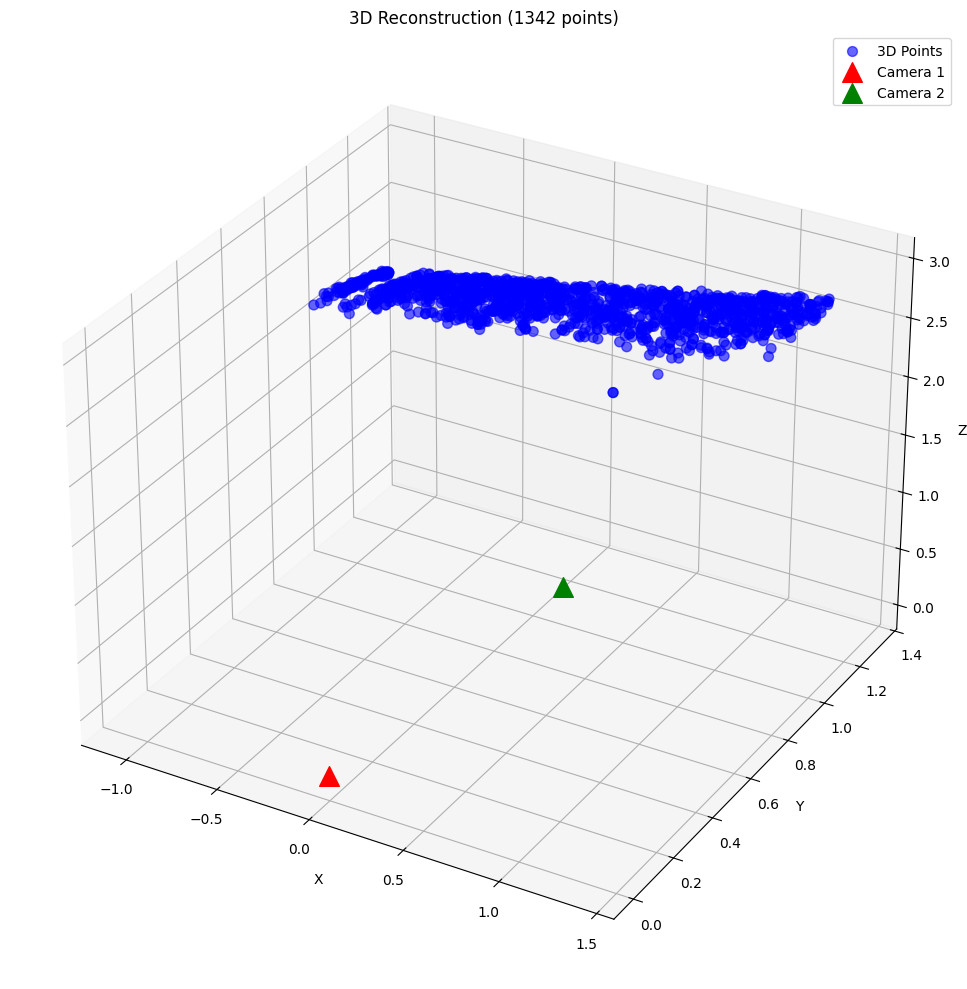

In [15]:

# Create 3D plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot 3D points
ax.scatter(points_3d[:, 0], points_3d[:, 1], points_3d[:, 2],
           c='blue', marker='o', s=50, alpha=0.6, label='3D Points')

# Plot camera positions
ax.scatter(0, 0, 0, c='red', marker='^', s=200, label='Camera 1')
ax.scatter(t[0], t[1], t[2], c='green', marker='^', s=200, label='Camera 2')

# Labels and legend
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title(f'3D Reconstruction ({len(points_3d)} points)')
ax.legend()

plt.tight_layout()
plt.show()


In [16]:
# Create point cloud mesh
points_mesh = trimesh.points.PointCloud(vertices=points_3d)

# Export to PLY
output_filename = 'real_object_reconstruction.ply'
points_mesh.export(output_filename)

print(f"Point cloud exported to: {output_filename}")

# Download the file
files.download(output_filename)
print("File ready for download!")


Point cloud exported to: real_object_reconstruction.ply


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File ready for download!


In [17]:
# Print final summary
print("="*50)
print("RECONSTRUCTION SUMMARY")
print("="*50)
print(f"Images processed: {image_files[0]} and {image_files[1]}")
print(f"Keypoints detected: {len(keypoints1)} and {len(keypoints2)}")
print(f"Feature matches: {len(good_matches)}")
print(f"Inliers after RANSAC: {num_inliers} ({inlier_rate:.1f}%)")
print(f"3D points reconstructed: {len(points_3d)}")
print(f"Output file: {output_filename}")
print("="*50)


RECONSTRUCTION SUMMARY
Images processed: real_object_views/IMG_2012 (1).JPG and real_object_views/IMG_2013 (1).JPG
Keypoints detected: 6083 and 10741
Feature matches: 1565
Inliers after RANSAC: 1342 (85.8%)
3D points reconstructed: 1342
Output file: real_object_reconstruction.ply
